<a href="https://colab.research.google.com/github/danjethh/steg_analysis/blob/main/Image_analysis_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install PyWavelets

Processing image: https://raw.githubusercontent.com/Sourish1997/steganalysis/master/bossbase_lsb_sample/14.pgm


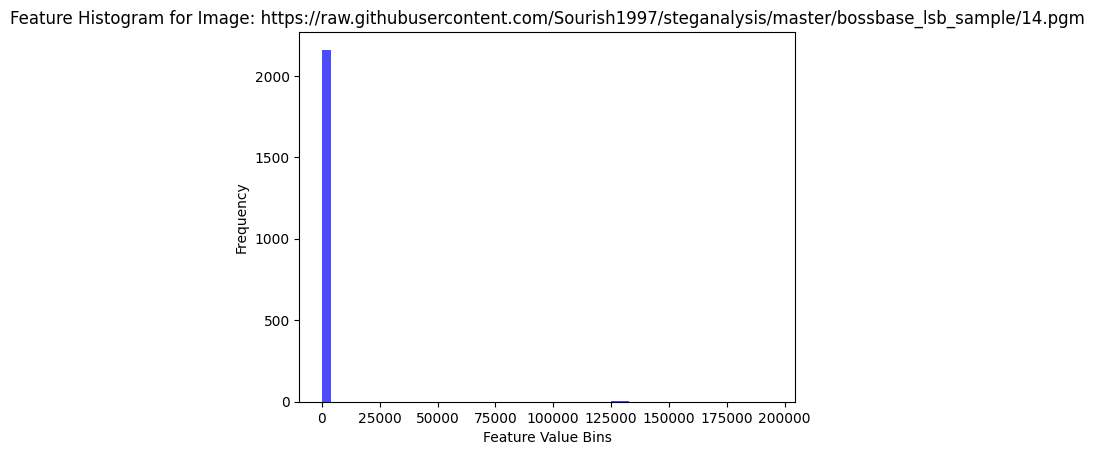

Feature values for https://raw.githubusercontent.com/Sourish1997/steganalysis/master/bossbase_lsb_sample/14.pgm :
[1.63419000e+05 9.87250000e+04 0.00000000e+00 ... 0.00000000e+00
 7.06147472e-01 8.27614527e-40]
Processing image: https://raw.githubusercontent.com/Sourish1997/steganalysis/master/bossbase_sample/15.pgm


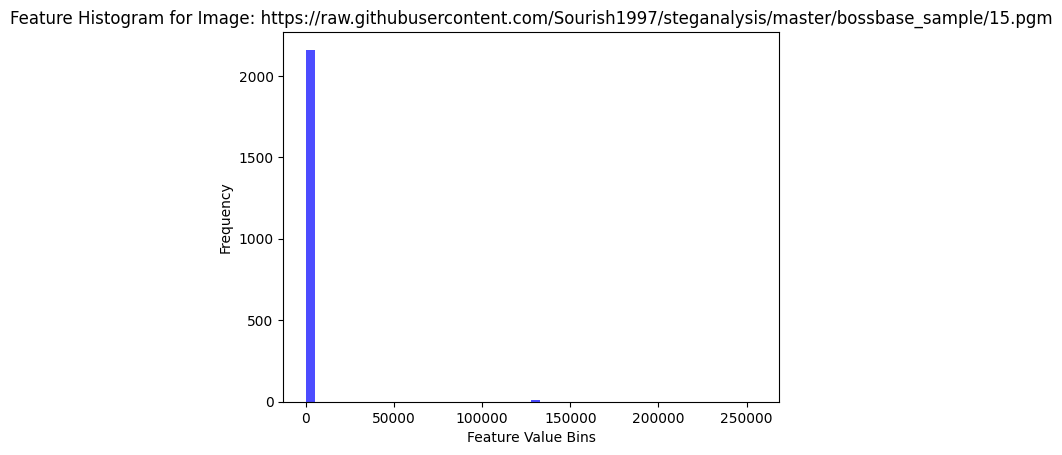

Feature values for https://raw.githubusercontent.com/Sourish1997/steganalysis/master/bossbase_sample/15.pgm :
[2.55805000e+05 6.33900000e+03 0.00000000e+00 ... 0.00000000e+00
 7.05186879e-01 1.16618755e-39]
Feature extraction and histogram visualization completed.


In [10]:
import numpy as np
from scipy import ndimage
from scipy.stats import pearsonr
import pywt
from skimage.io import imread
import os
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image

# Function to extract a specific bit plane from an image's binary representation
def getPlaneBits(planeId, binary_image):
    # Extracts the bit at the given plane index (0-7) for all pixels
    return [int(b[planeId]) for b in binary_image]

# Function to compute all bit planes of a grayscale image
def getBitPlanes(img):
    bin_image = []  # Holds binary representation of all pixel values
    bit_planes = []  # Holds each bit plane as a separate image
    img_height, img_width = img.shape  # Dynamically determine image size

    # Convert pixel values to binary (8-bit representation)
    for i in range(img_height):
        for j in range(img_width):
            bin_image.append(np.binary_repr(int(img[i][j]), width=8))

    # Generate bit planes using binary data
    for i in range(8):
        bit_planes.append(np.array(getPlaneBits(i, bin_image)).reshape(img_height, img_width))

    return bit_planes

# Function to calculate autocorrelation for feature extraction
def autocor(A, k, l):
    img_height, img_width = A.shape
    # Ensure the subarrays have the same size to avoid PearsonR length mismatch
    Xk = A[0:img_height - k, 0:img_width - l]
    Xl = A[k:img_height, l:img_width]
    if Xk.size != Xl.size:
        return (0, 1)  # Return a neutral correlation if lengths mismatch
    return pearsonr(Xk.flatten(), Xl.flatten())

# Function to compute cross-correlation histograms for features
def getCHl(img_hist, l):
    if l >= len(img_hist):
        return (0, 1)
    Hl1 = img_hist[0:len(img_hist) - l]
    Hl2 = img_hist[l:len(img_hist)]
    if len(Hl1) != len(Hl2):
        return (0, 1)
    return pearsonr(Hl1, Hl2)

# Haar wavelet thresholding for feature extraction
def getModifiedWavelet(C, t):
    return np.where(np.abs(C) < t, 0, C)

# Function to compute the residual image E using Haar wavelet
def getE(img, t):
    coeffs = pywt.dwt2(img, 'haar')
    LL, (LH, HL, HH) = coeffs

    LH = getModifiedWavelet(LH, t)
    HL = getModifiedWavelet(HL, t)
    HH = getModifiedWavelet(HH, t)

    img_denoised = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
    E = img - img_denoised  # Residual image computation

    return E

# Main feature extraction function
def extract_features(img):
    E = getE(img, 2)  # Thresholding with t=2
    bit_planes = getBitPlanes(img)

    features = []
    for i in range(8):
        # Calculate histogram and autocorrelation features
        hist, _ = np.histogram(bit_planes[i].flatten(), bins=256, range=(0, 255))
        features.extend(hist)
        for k in range(2):
            for l in range(2):
                features.extend(autocor(E, k, l))
                features.extend(getCHl(hist, l))

    return np.array(features)

# Define image paths
image_paths = [
    'https://raw.githubusercontent.com/Sourish1997/steganalysis/master/bossbase_lsb_sample/14.pgm',
    'https://raw.githubusercontent.com/Sourish1997/steganalysis/master/bossbase_sample/15.pgm'
]

all_features = []

# Process each image, extract features, and display histograms
for image_path in image_paths:
    print(f'Processing image: {image_path}')
    response = requests.get(image_path)
    img = imread(BytesIO(response.content), as_gray=True)
    features = extract_features(img)
    all_features.append(features)

    # Plot and display the feature histogram
    plt.figure()
    plt.hist(features, bins=50, color='blue', alpha=0.7)
    plt.title(f'Feature Histogram for Image: {image_path}')
    plt.xlabel('Feature Value Bins')
    plt.ylabel('Frequency')
    plt.show()

    # Output the actual feature values
    print(f'Feature values for {image_path} :')
    print(features)

print("Feature extraction and histogram visualization completed.")
